In [1]:
# Imports we will use
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Function
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
#from torchsummary import summary
from sklearn.metrics import r2_score

# For matplotlib
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

# Set Seed
torch.manual_seed(22)

# Find if cuda is available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [2]:
# Load data function
def create_dataloader(img_path, metadata_path, batch_size):
    '''
    Creates dataloader for training, reserving the last 1000 images for validation/testing
    '''
    data = np.load(img_path).squeeze()
    length = len(data)
    data_train = torch.tensor(data[:int(.7*length)])
    data_test = torch.tensor(data[int(.7*length):int(.9*length)])
    data_val = torch.tensor(data[int(.9*length):])

    metadata = pd.read_csv(metadata_path)
    labels = metadata['PLANE_1-OBJECT_1-MASS_PROFILE_1-theta_E-g'].tolist()
    labels_train = torch.tensor(labels[:int(.7*length)])
    labels_test = torch.tensor(labels[int(.7*length):int(.9*length)])
    labels_val = torch.tensor(labels[int(.9*length):])

    data_train.cuda()
    data_test.cuda()
    data_val.cuda()
    labels_train.cuda()
    labels_test.cuda()
    labels_val.cuda()

    train_dataset = TensorDataset(data_train, labels_train)
    test_dataset = TensorDataset(data_test, labels_test)
    val_dataset = TensorDataset(data_val, labels_val)

    train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=True)

    return train_dataloader, test_dataloader, val_dataloader, data

In [3]:
#mount to drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
# Load in data
source_img_path = '/content/gdrive/MyDrive/deepskies/pax_source.npy'
target_img_path = '/content/gdrive/MyDrive/deepskies/pax_target.npy'
source_meta = '/content/gdrive/MyDrive/deepskies/pax_source_metadata.csv'
target_meta = '/content/gdrive/MyDrive/deepskies/pax_target_metadata.csv'
batch_size = 32
source_train_dataloader, source_test_dataloader, source_val_dataloader, source_data = create_dataloader(source_img_path,
                                                                                                        source_meta, batch_size)
target_train_dataloader, target_test_dataloader, target_val_dataloader, target_data = create_dataloader(target_img_path,
                                                                                                        target_meta, batch_size)

In [6]:
# Define data visualization function
def visualize_data(data):
    '''
    visualizes 16 random images from dataset
    '''
    #get random indices
    x = np.empty(1)
    i = 1

    while i < 16:
        example_num = int(random.randrange(0, len(data[0:])))
        if example_num != x[i-1]:
            x = np.append(x, [example_num])
            i += 1

    #plot the examples for source
    fig1=plt.figure(figsize=(8,8))

    for i in range(16):
        plt.subplot(4, 4, i + 1)
        plt.axis("off")

        example_indices = int(x[i])

        example_image = np.squeeze(data[example_indices:(example_indices + 1)]) #change band by switching 0:1 to 1:2 or 2:3

        plt.imshow(example_image, aspect='auto', cmap='viridis')

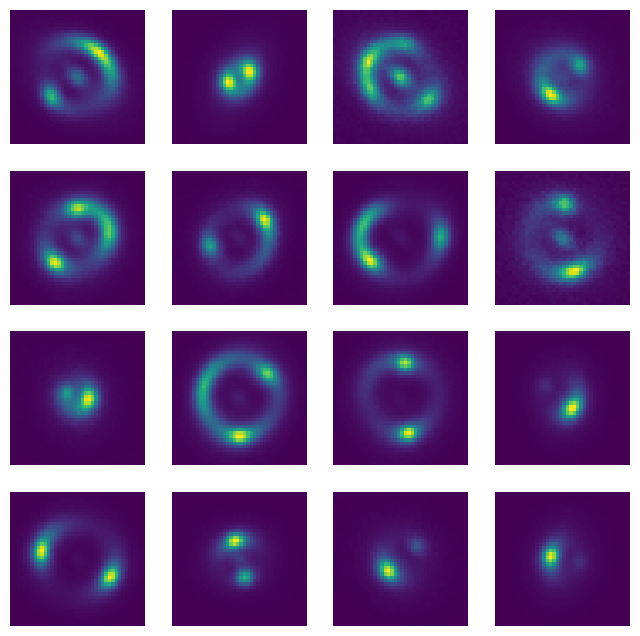

In [7]:
# Visualize source data
visualize_data(source_data)

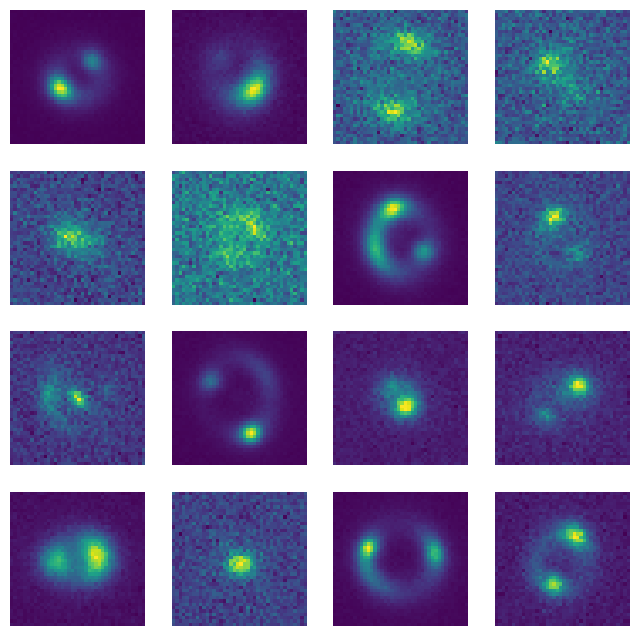

In [8]:
# Visualize target data
visualize_data(target_data)

In [9]:
# Define and initialize model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.feature = nn.Sequential()
        self.feature.add_module('f_conv1', nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, padding='same'))
        self.feature.add_module('f_relu1', nn.ReLU(True))
        self.feature.add_module('f_bn1', nn.BatchNorm2d(8))
        self.feature.add_module('f_pool1', nn.MaxPool2d(kernel_size=2, stride=2))
        self.feature.add_module('f_conv2', nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding='same'))
        self.feature.add_module('f_relu2', nn.ReLU(True))
        self.feature.add_module('f_bn2', nn.BatchNorm2d(16))
        self.feature.add_module('f_pool2', nn.MaxPool2d(kernel_size=2, stride=2))
        self.feature.add_module('f_conv3', nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding='same'))
        self.feature.add_module('f_relu3', nn.ReLU(True))
        self.feature.add_module('f_bn3', nn.BatchNorm2d(32))
        self.feature.add_module('f_pool3', nn.MaxPool2d(kernel_size=2, stride=2))

        self.regressor = nn.Sequential()
        self.regressor.add_module('r_fc1', nn.Linear(in_features=32*5*5, out_features=128))
        self.regressor.add_module('r_relu1', nn.ReLU(True))
        #self.regressor.add_module('r_fc2', nn.Linear(in_features=128, out_features=64))
        #self.regressor.add_module('r_relu2', nn.ReLU(True))
        self.regressor.add_module('r_fc3', nn.Linear(in_features=128, out_features=1))

    def forward(self, x):
        x = x.view(-1, 1, 40, 40)

        features = self.feature(x)
        features = features.view(-1, 32*5*5)
        estimate = self.regressor(features)
        estimate = F.relu(estimate)
        estimate = estimate.view(-1)

        return estimate, features



In [11]:
# code from https://github.com/ZongxianLee/MMD_Loss.Pytorch

class MMD_loss(nn.Module):
    def __init__(self, kernel_mul = 2.0, kernel_num = 5):
        super(MMD_loss, self).__init__()
        self.kernel_num = kernel_num
        self.kernel_mul = kernel_mul
        self.fix_sigma = None
        return
    def guassian_kernel(self, source, target, kernel_mul=2.0, kernel_num=5, fix_sigma=None):
        n_samples = int(source.size()[0])+int(target.size()[0])
        total = torch.cat([source, target], dim=0)

        total0 = total.unsqueeze(0).expand(int(total.size(0)), int(total.size(0)), int(total.size(1)))
        total1 = total.unsqueeze(1).expand(int(total.size(0)), int(total.size(0)), int(total.size(1)))
        L2_distance = ((total0-total1)**2).sum(2)
        if fix_sigma:
            bandwidth = fix_sigma
        else:
            bandwidth = torch.sum(L2_distance.data) / (n_samples**2-n_samples)
        bandwidth /= kernel_mul ** (kernel_num // 2)
        bandwidth_list = [bandwidth * (kernel_mul**i) for i in range(kernel_num)]
        kernel_val = [torch.exp(-L2_distance / bandwidth_temp) for bandwidth_temp in bandwidth_list]
        return sum(kernel_val)

    def forward(self, source, target):
        batch_size = int(source.size()[0])
        kernels = self.guassian_kernel(source, target, kernel_mul=self.kernel_mul, kernel_num=self.kernel_num, fix_sigma=self.fix_sigma)
        XX = kernels[:batch_size, :batch_size]
        YY = kernels[batch_size:, batch_size:]
        XY = kernels[:batch_size, batch_size:]
        YX = kernels[batch_size:, :batch_size]
        loss = torch.mean(XX + YY - XY -YX)
        return loss

In [12]:
# Define training loop
def train_loop(source_dataloader, target_dataloader, model, regressor_loss_fn, da_loss, optimizer, n_epoch, epoch):

    domain_error = 0
    domain_classifier_accuracy = 0
    estimator_error = 0
    score_list = np.array([])

    len_dataloader = min(len(source_dataloader), len(target_dataloader))
    data_source_iter = iter(source_dataloader)
    data_target_iter = iter(target_dataloader)

    i = 0
    while i < len_dataloader:

        p = float(i + epoch * len_dataloader) / n_epoch / len_dataloader
        alpha = 2. / (1. + np.exp(-10 * p)) - 1

        # Source Training

        data_source = next(data_source_iter)
        X, y = data_source
        X = X.float()
        X = X.cuda()
        y = y.cuda()

        model.zero_grad()
        batch_size = len(y)

        domain_label = torch.zeros(batch_size)
        domain_label = domain_label.long()
        domain_label = domain_label.cuda()

        estimate_output, domain_output_source = model(X)

        estimate_loss = regressor_loss_fn(estimate_output, y)

        # Target Training

        data_target = next(data_target_iter)
        X_target, _ = data_target
        X_target = X_target.float()
        X_target = X_target.cuda()

        batch_size = len(X_target)

        _, domain_output_target = model(X_target)
        domain_loss = da_loss(domain_output_source, domain_output_target)

        loss = estimate_loss + domain_loss*1.4
        loss.backward()
        optimizer.step()

        # Update values

        domain_error += domain_loss.item()
        #domain_classifier_accuracy +=
        estimator_error += estimate_loss.item()
        score = r2_score(y.cpu().detach().numpy(), estimate_output.cpu().detach().numpy())
        score_list = np.append(score_list, score)

        i += 1

    score = np.mean(score_list)
    domain_error = domain_error / (len_dataloader)
    estimator_error /= len_dataloader

    return [domain_error, estimator_error, score]

In [13]:
# Define testing loop

def test_loop(source_dataloader, target_dataloader, model, regressor_loss_fn, da_loss, n_epoch, epoch):

    with torch.no_grad():

        len_dataloader = min(len(source_dataloader), len(target_dataloader))
        data_source_iter = iter(source_dataloader)
        data_target_iter = iter(target_dataloader)

        domain_classifier_error = 0
        domain_classifier_accuracy = 0
        estimator_error = 0
        estimator_error_target = 0
        score_list = np.array([])
        score_list_target = np.array([])

        i = 0
        while i < len_dataloader:

            p = float(i + epoch * len_dataloader) / n_epoch / len_dataloader
            alpha = 2. / (1. + np.exp(-10 * p)) - 1

            # Source Testing

            data_source = next(data_source_iter)
            X, y = data_source
            X = X.float()
            X = X.cuda()
            y = y.cuda()

            batch_size = len(y)

            #domain_label = torch.zeros(batch_size)
            #domain_label = domain_label.long()
            #domain_label = domain_label.cuda()

            estimate_output, domain_output = model(X)

            estimate_loss = regressor_loss_fn(estimate_output, y)
            #domain_loss_source = classifier_loss_fn(domain_output, domain_label)

            # Target Testing

            data_target = next(data_target_iter)
            X_target, y_target = data_target
            X_target = X_target.float()
            X_target = X_target.cuda()
            y_target = y_target.cuda()

            batch_size = len(X_target)

            #domain_label = torch.ones(batch_size)
            #domain_label = domain_label.long()
            #domain_label = domain_label.cuda()

            estimate_output_target, domain_output = model(X_target)

            estimate_loss_target = regressor_loss_fn(estimate_output_target, y_target)
            #domain_loss_target = classifier_loss_fn(domain_output, domain_label)

            # Update values

           # domain_classifier_error += domain_loss_source.item()
            #domain_classifier_error += domain_loss_target.item()
            #domain_classifier_accuracy +=
            estimator_error += estimate_loss.item()
            estimator_error_target += estimate_loss_target.item()
            score = r2_score(y.cpu(), estimate_output.cpu())
            score_list = np.append(score_list, score)
            score_target = r2_score(y_target.cpu(), estimate_output_target.cpu())
            score_list_target = np.append(score_list_target, score_target)

            i += 1

        score = np.mean(score_list)
        score_target = np.mean(score_list_target)
        #classifier_error = domain_classifier_error / (len_dataloader * 2)
        estimator_error /= len_dataloader
        estimator_error_target /= len_dataloader
    classifier_error = 1
    return [classifier_error, estimator_error, estimator_error_target, score, score_target]

In [14]:
# Initialize dictionary for training stats
import time
model = NeuralNetwork().cuda()
# Hyper parameter presets
learning_rate = 6e-5
epochs = 30
# Define loss functions and optimizer
regressor_loss_fn = nn.MSELoss().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
da_loss = MMD_loss()

stats = {'train_domain_classifier_error':[],
             'train_estimator_error':[],
             'train_score':[],
             'val_domain_classifier_error':[],
             'val_estimator_error':[],
             'val_estimator_error_target':[],
             'val_score':[],
             'val_score_target':[]}

# Train
for i in range(epochs):
        start_time = time.time()
        print(f"Epoch {i+1}\n-------------------------------")
        vals = train_loop(source_train_dataloader, target_train_dataloader, model,
                   regressor_loss_fn, da_loss, optimizer, epochs, i)

        vals_validate = test_loop(source_val_dataloader, target_val_dataloader,
                         model, regressor_loss_fn, da_loss, epochs, i)
        print(time.time() - start_time)
        to_print = (
            f'Train Estimator Error = {vals[1]}\n'
            f'Train Estimator R2 Score = {vals[2]:.4f}\n'
            f'Train Domain Classifier Error = {vals[0]}\n'
            f'Validation Source Estimator Error = {vals_validate[1]}\n'
            f'Validation Source R2 Score = {vals_validate[3]:.4f}\n'
            f'Validation Target Estimator Error = {vals_validate[2]}\n'
            f'Validation Target R2 Score = {vals_validate[4]:.4f}\n'
            f'Validation Domain Classifier Error = {vals_validate[0]}\n'
        )

        print(to_print)

Epoch 1
-------------------------------
11.304649591445923
Train Estimator Error = 0.16441153093893252
Train Estimator R2 Score = 0.6711
Train Domain Classifier Error = 0.1972575980073464
Validation Source Estimator Error = 0.03979311020938075
Validation Source R2 Score = 0.9176
Validation Target Estimator Error = 0.17961284456549176
Validation Target R2 Score = 0.6386
Validation Domain Classifier Error = 1

Epoch 2
-------------------------------
10.53866171836853
Train Estimator Error = 0.034023126222915145
Train Estimator R2 Score = 0.9312
Train Domain Classifier Error = 0.10589194365213514
Validation Source Estimator Error = 0.026606692653742565
Validation Source R2 Score = 0.9447
Validation Target Estimator Error = 0.12459687314405563
Validation Target R2 Score = 0.7483
Validation Domain Classifier Error = 1

Epoch 3
-------------------------------
10.403320074081421
Train Estimator Error = 0.02588616100002005
Train Estimator R2 Score = 0.9477
Train Domain Classifier Error = 0.098

Source R2 Score is 0.9781


Text(0.5, 1.0, 'MMD - Source')

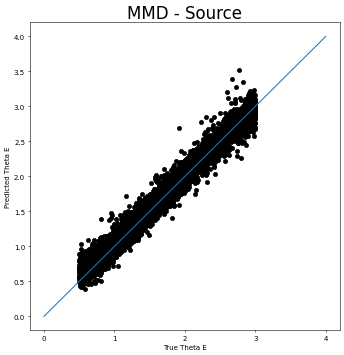

In [15]:
# Test Source
preds = np.array([])
true = np.array([])
score_list = np.array([])

with torch.no_grad():
    for X, y in source_test_dataloader:
        X = X.float()
        pred, _ = model(X.cuda())
        preds = np.append(preds, pred.cpu())
        true = np.append(true, y.cpu())
        score = r2_score(y.cpu(), pred.cpu())
        score_list = np.append(score_list, score)

score = np.mean(score_list)
print(f'Source R2 Score is {score:.4f}')

plt.figure(figsize=(8,8),dpi=50)
plt.scatter(true, preds,  color='black')
line = np.linspace(0, 4, 100)
plt.plot(line, line)
plt.rc('font', size=12)
plt.xlabel('True Theta E')
plt.ylabel('Predicted Theta E');
plt.rc('font', size=20)
plt.title('MMD - Source')

Target R2 Score is 0.9365


Text(0.5, 1.0, 'MMD - Target')

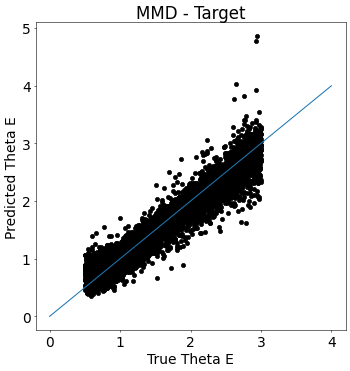

In [16]:
# Test target
preds = np.array([])
true = np.array([])
score_list = np.array([])

with torch.no_grad():
    for X, y in target_test_dataloader:
        X = X.float()
        pred, _ = model(X.cuda())
        preds = np.append(preds, pred.cpu())
        true = np.append(true, y.cpu())
        score = r2_score(y.cpu(), pred.cpu())
        score_list = np.append(score_list, score)

score = np.mean(score_list)
print(f'Target R2 Score is {score:.4f}')

plt.figure(figsize=(8,8),dpi=50)
plt.scatter(true, preds,  color='black')
line = np.linspace(0, 4, 100)
plt.plot(line, line)
plt.rc('font', size=12)
plt.xlabel('True Theta E')
plt.ylabel('Predicted Theta E');
plt.rc('font', size=20)
plt.title('MMD - Target')